In [5]:
!git clone https://github.com/openai/multiagent-particle-envs.git
!pip install gym==0.10.5

fatal: destination path 'multiagent-particle-envs' already exists and is not an empty directory.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [6]:
cd multiagent-particle-envs

/content/multiagent-particle-envs


In [7]:
pip install -e.

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Obtaining file:///content/multiagent-particle-envs
  Attempting uninstall: multiagent
    Found existing installation: multiagent 0.0.1
    Can't uninstall 'multiagent'. No files were found to uninstall.
  Running setup.py develop for multiagent


In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as f
import torch.optim as optim
from torch.autograd import Variable as v
from make_env import make_env
env = make_env("simple_reference")

In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as f
import torch.optim as optim
from torch.autograd import Variable as v

class Actor(nn.Module):
  def __init__(self,state_size,action_size,message_size):
    super(Actor,self).__init__()
    self.fc3 = nn.Linear(64,128)
    self.fc4 = nn.Linear(128,256)
    self.fc5 = nn.Linear(256,512)
    self.fc6 = nn.Linear(512,512)
    self.fc7 = nn.Linear(512,256)
    self.fc8 = nn.Linear(256,128)
    self.fc9 = nn.Linear(128,64)
    self.fc10= nn.Linear(64,32)
    self.fc11= nn.Linear(32,5)
  def forward(self,state,message):
    message  = torch.tensor([message.item(),0],dtype = torch.float32)
    self.fc1 = nn.Linear(state.shape[0],32)
    self.fm1 = nn.Linear(message.shape[0],32)
    #state    = torch.tensor(state,dtype = torch.float64)
    state    =  torch.tensor(state).float()
    s        = self.fc1(state)
    m        = self.fm1(message)
    cat      = torch.cat([s,m],0)
    cat      = torch.reshape(cat,(-1,))
    self.fc2 = nn.Linear(cat.shape[0],64)
    x        = f.relu(self.fc8(f.relu(self.fc7(f.relu(self.fc6(f.relu(self.fc5(f.relu(self.fc4(f.relu(self.fc3(f.relu(self.fc2(cat))))))))))))))
    x        = f.relu(self.fc10(f.relu(self.fc9(x))))
    x        = f.softmax(self.fc11(x))
    return x

In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as f
import torch.optim as optim
from torch.autograd import Variable as v

class Critic(nn.Module):
  def __init__(self,state_size,action_size,message_size):
    super(Critic,self).__init__()
    self.fc3 = nn.Linear(64,128)
    self.fc4 = nn.Linear(128,256)
    self.fc5 = nn.Linear(256,512)
    self.fc6 = nn.Linear(512,512)
    self.fc7 = nn.Linear(512,256)
    self.fc8 = nn.Linear(256,128)
    self.fc9 = nn.Linear(128,64)
    self.fc10= nn.Linear(64,32)
    self.fc11= nn.Linear(32,1)
  def forward(self,state,action,reward):
    reward   = torch.tensor([reward.item(),0],dtype = torch.float64)
    self.fc1 = nn.Linear(state.shape[0],32)
    self.fa1 = nn.Linear(action.shape[0],32)
    self.fr1 = nn.Linear(reward.shape[0],32)
    #state    = torch.tensor(state[0],dtype = torch.float64)
    state    = torch.tensor(state).float()
    reward   = torch.tensor(reward).float()
    s        = self.fc1(state)
    a        = self.fa1(action)
    r        = self.fr1(reward)
    cat      = torch.cat([s,a,r],0)
    cat      = torch.reshape(cat,(-1,))
    self.fc2 = nn.Linear(cat.shape[0],64)
    x        = f.relu(self.fc8(f.relu(self.fc7(f.relu(self.fc6(f.relu(self.fc5(f.relu(self.fc4(f.relu(self.fc3(f.relu(self.fc2(cat))))))))))))))
    x        = f.relu(self.fc10(f.relu(self.fc9(x))))
    x        = self.fc11(x)
    return x

In [11]:
import torch
import torch.nn as nn
import torch.nn.functional as f
import torch.optim as optim
from torch.autograd import Variable as v

class Message(nn.Module):
  def __init__(self,state_size,action_size,message_size):
    super(Message,self).__init__()
    self.state_size  = state_size
    self.action_size = action_size
    self.q           = nn.Linear(5,128)
  def para(self,parameters):
    count  = len(parameters)
    vector = nn.Embedding(1024,128)
    vectors = []
    for i in range(count):
      out  = vector(parameters[i].long())
      vectors.append(torch.reshape(out,(-1,)))
    vectors = torch.cat(vectors,0)
    return vectors
  def message(self,action,value,vectors,message):
    message= torch.tensor(message).float()
    q = nn.Linear(5,128)
    k = nn.Linear(value.shape[0],128)
    v = nn.Linear(vectors.shape[1],128)
    m = nn.Linear(message.shape[0],128)
    wq = self.q(action)
    wk = k(value)
    wv = v(vectors)
    wm = m(message)
    mat1 = torch.matmul(wq,wk)
    mat2 = torch.matmul(wv,wm)
    mat1 = torch.tensor([mat1])
    mat2 = torch.reshape(mat2,(self.sha,1))
    msg  = torch.matmul(mat2,mat1)
    return msg
  def forward(self,action,value,message,para):
    para = self.para(para)
    self.sha  =int(para.shape[0]/32)
    para = torch.reshape(para , (self.sha,32))
    msg  = self.message(action,value,para,message)
    msg  = f.softmax(msg)
    msg  = msg.mean()
    return msg

In [12]:
agent1_msg = []
agent2_msg = []
agent1_val = []
agent2_val = []
count      = []

In [30]:
import torch
import torch.nn as nn
import torch.nn.functional as f
import torch.optim as optim
from torch.autograd import Variable as v
import sys
sys.path.append('./')
from network.network import Actor,Critic,Message

class Agent1:
  def __init__(self,state_size,action_size,reward_size,message_size,buffer):
    self.state_size = state_size
    self.action_size = action_size
    self.reward_size = reward_size
    self.buffer = buffer
    self.message_size = message_size 
    self.gamma = 0.99
    self.lamda= 0.95
    self.lr1 = 0.000005
    self.lr2 = 0.00007
    self.device= torch.device("cuda" if torch.cuda.is_available() else "cpu")
    self.actor = Actor(self.state_size,self.action_size,self.message_size).to(self.device)
    self.critic= Critic(self.state_size,self.action_size,self.message_size).to(self.device)
    self.message = Message(self.state_size,self.action_size,self.reward_size).to(self.device)
    self.actor_optim = optim.Adam(self.actor.parameters(),lr = self.lr1)
    self.critic_optim = optim.Adam(self.critic.parameters(),lr = self.lr2)
    self.message_optim = optim.Adam(self.message.parameters() ,lr = self.lr1)
    self.value         = []
    self.policy        = []
  def message(self,action,value,message,para):
    #parameters = list(self.actor.parameters())
    msg     = self.message(action,value,message,para)
    return msg
  def choose_action(self,state,message):
    state   = state
    act     = self.actor(state,message).to(self.device)
    return act
  def values(self,state,action,reward,noise):
    state   = state + noise 
    value   = self.critic(state,action,reward).to(self.device)
    return value
  def returns(self,reward,done,value,next_value):
    returns = []
    gae     = 0
    for i in range(5):
      delta = reward + self.gamma * (1-done) * next_value  - value
      gae   = delta + gae*self.lamda * (1-done)
      returns.insert(0,gae + value)
    return returns
  def msg_loss(self,action,p_action,value,reward,done,msg):
    l2    = torch.log(p_action) - torch.log(action)
    l2    = l2*value
    loss  = reward + l2*(1-done)*msg*value
    loss  = self.lamda*loss.mean()
    return loss
  def learn(self,state,next_state,reward,done,msg,next_value,noise):
    state        = torch.tensor(state).float().to(self.device)
    reward       = torch.tensor(reward,dtype = torch.float32).to(self.device)
    done         = torch.tensor(done ,dtype = torch.float32).to(self.device)
    action       = self.choose_action(state,msg)
    value        = self.values(state,action,reward,noise)
    para         = list(self.actor.parameters())
    msg          = self.message(action,value,msg,para)
    #agent1_msg.append(torch.tensor([msg]).float())
    self.policy.append(action)
    self.value.append(value)
    self.buffer.agent1_val.append(torch.tensor(value).float())
    self.buffer.agent1_mg.append(torch.tensor([msg]).float())
    advantage = self.returns(reward,done,value,next_value)
    advantage = torch.tensor([advantage[0][0],advantage[1][0],advantage[2][0],advantage[3][0],advantage[4][0]]) - value
    argmax      = torch.argmax(torch.tensor(self.value))
    p_action    = self.policy[argmax.item()]
    actor_loss  = p_action - action
    actor_loss  = actor_loss.mean()
    critic_loss = (advantage - value)**2
    critic_loss = critic_loss.mean()
    loss        = actor_loss + critic_loss*0.5
    loss        = v(loss,requires_grad = True)
    self.actor_optim.zero_grad()
    self.critic_optim.zero_grad()
    loss.backward()
    self.actor_optim.step()
    self.critic_optim.step()
    #message
    msg_loss   = self.msg_loss(action,p_action,value,reward,done,msg)
    self.buffer.appending_ag1(reward,value,msg,loss,actor_loss,critic_loss,msg_loss,advantage,next_value)
    msg_loss   = v(msg_loss.mean() ,requires_grad = True)
    self.message_optim.zero_grad()
    msg_loss.backward()
    self.message_optim.step()

In [31]:
import torch
import torch.nn as nn
import torch.nn.functional as f
import torch.optim as optim
from torch.autograd import Variable as v
import sys
sys.path.append('./')
from network.network import Actor,Critic,Message

class Agent2:
  def __init__(self,state_size,action_size,reward_size,message_size,buffer):
    self.state_size = state_size
    self.action_size = action_size
    self.buffer = buffer
    self.reward_size = reward_size
    self.message_size = message_size 
    self.gamma = 0.99
    self.lamda= 0.95
    self.lr1 = 0.0000009
    self.lr2 = 0.000003
    self.device= torch.device("cuda" if torch.cuda.is_available() else "cpu")
    self.actor = Actor(self.state_size,self.action_size,self.message_size).to(self.device)
    self.critic= Critic(self.state_size,self.action_size,self.message_size).to(self.device)
    self.message = Message(self.state_size,self.action_size,self.reward_size).to(self.device)
    self.actor_optim = optim.Adam(self.actor.parameters(),lr = self.lr1)
    self.critic_optim = optim.Adam(self.critic.parameters(),lr = self.lr2)
    self.message_optim = optim.Adam(self.message.parameters() ,lr = self.lr1)
    self.value         = []
    self.policy        = []
  def message(self,action,value,message,para):
    #parameters = list(self.actor.parameters())
    msg = self.message(action,value,message,para)
    return msg
  def choose_action(self,state,message):
    state = state
    act   = self.actor(state,message).to(self.device)
    return act
  def values(self,state,action,reward,noise):
    state = state + noise 
    value = self.critic(state,action,reward).to(self.device)
    return value
  def returns(self,reward,done,value,next_value):
    returns = []
    gae     = 0
    for i in range(5):
      delta = reward + self.gamma * (1-done) * next_value  - value
      gae   = delta + gae*self.lamda * (1-done)
      returns.insert(0,gae + value)
    return returns
  def msg_loss(self,action,p_action,value,reward,done,msg):
    l2 = torch.log(p_action) - torch.log(action)
    l2 = l2*value
    loss = reward + l2*(1-done)*msg*value
    loss = self.lamda*loss.mean()
    return loss

  def learn(self,state,next_state,reward,done,msg,next_value,noise):
    #converting to tensors
    state     = torch.tensor(state).float().to(self.device)
    reward    = torch.tensor(reward,dtype = torch.float32).to(self.device)
    done      = torch.tensor(done ,dtype = torch.float32).to(self.device)
    action    = self.choose_action(state,msg)
    value     = self.values(state,action,reward,noise)
    para      = list(self.actor.parameters())
    msg       = self.message(action,value,msg,para)
    self.policy.append(action)
    self.value.append(value)
    self.buffer.agent2_val.append(torch.tensor(value).float())
    self.buffer.agent2_mg.append(torch.tensor([msg]).float())
    returns = self.returns(reward,done,value,next_value)
    returns = torch.tensor([returns[0][0],returns[1][0],returns[2][0],returns[3][0],returns[4][0]]) 
    advantage = returns-value
    argmax    = torch.argmax(torch.tensor(self.value))
    p_action  = self.policy[argmax.item()]
    actor_loss= p_action - action
    actor_loss= actor_loss.mean()
    critic_loss= (returns - value)**2
    critic_loss = critic_loss.mean()
    loss = actor_loss + critic_loss*0.5
    loss = v(loss,requires_grad = True)
    self.actor_optim.zero_grad()
    self.critic_optim.zero_grad()
    loss.backward()
    self.actor_optim.step()
    self.critic_optim.step()
    #message
    msg_loss = self.msg_loss(action,p_action,value,reward,done,msg)
    msg_loss = v(msg_loss.mean() ,requires_grad =True)
    self.buffer.appending_ag2(reward,value,msg,loss,actor_loss,critic_loss,msg_loss,returns,next_value)
    self.message_optim.zero_grad()
    msg_loss.backward()
    self.message_optim.step()

In [32]:
import torch
import torch.nn as nn
import torch.nn.functional as f
import torch.optim as optim
from torch.autograd import Variable as v
from make_env import make_env
env = make_env("simple_reference")
import sys
sys.path.append('./')
from network.network import Critic
from Agents.Agent1 import Agent1
from Agents.Agent2 import Agent2
class Centeral:
  def __init__(self,state_size,action_size,reward_size,message_size,n_games,step,buffer):
    self.state_size = state_size
    self.action_size  = action_size
    self.reward_size = reward_size
    self.message_size = message_size
    self.n_games = n_games
    self.step = step
    self.buffer = buffer
    self.device       = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    self.agent1       = Agent1(self.state_size,self.action_size,self.reward_size,self.message_size,self.buffer)
    self.agent2       = Agent2(self.state_size,self.action_size,self.reward_size,self.message_size,self.buffer)
    self.critic       = Critic(self.state_size,self.action_size,self.message_size).to(self.device)
    self.optim        = optim.Adam(self.critic.parameters() ,lr = 0.000009)
  def noise(self,state):
    obs1,obs2 = state[0],state[1]
    n1    = torch.rand(state[0].size)+ state[1] 
    n1    = f.softmax(n1)
    n2    = torch.rand(state[1].size)+ state[0] 
    n2    = f.softmax(n2)
    noise = []
    noise.append(n1)
    noise.append(n2)
    return noise
  def choose_action(self,state,noise,msg):
    actions = []
    obs1 = torch.from_numpy(state[0]).float().to(self.device)
    obs2 = torch.from_numpy(state[1]).float().to(self.device)
    obs1 = obs1+ noise[0]
    obs2  = obs2+ noise[1]
    obs1 = torch.tensor(obs1,dtype = torch.float32).to(self.device)
    obs2 = torch.tensor(obs2,dtype = torch.float32).to(self.device)
    m1 = torch.tensor(msg[0].item(),dtype = torch.long).to(self.device)
    m2 = torch.tensor(msg[1].item(),dtype = torch.long).to(self.device)
    act1 = self.agent1.choose_action(obs1,m1).to(self.device)
    act2 = self.agent2.choose_action(obs2,m2).to(self.device)
    actions.append(act1.detach().numpy())
    actions.append(act2.detach().numpy())
    #actions.append(act3)
    return actions
  def next_value(self,state,action,reward,noise):
    values = []
    action[0],action[1] = torch.tensor(action[0],dtype = torch.float32).to(self.device),torch.tensor(action[1],dtype = torch.float32).to(self.device)
    reward[0],reward[1] = torch.tensor(reward[0],dtype = torch.float32).to(self.device),torch.tensor(reward[1],dtype = torch.float32).to(self.device)
    state[0],state[1] = torch.from_numpy(state[0]).float().to(self.device),torch.from_numpy(state[1]).float().to(self.device)
    state[0],state[1] = state[0]+noise[0],state[1]+noise[1]
    state[0] = torch.DoubleTensor(state[0])
    va1  = self.critic(state[0],action[0],reward[0])
    va2  = self.critic(state[1],action[1],reward[1])
    values.append(va1)
    values.append(va2)
    return values
  def returns(self,reward,values,idx):
    gae = 0
    delta = sum(reward)*0.99*sum(values) + self.buffer.agent1_val[idx] +self.buffer.agent2_val[idx]
    gae = delta + 0.95*gae+sum(reward)
    return gae
  def update(self,state,next_state,done,reward,noise,msg,idx):
    actions = self.choose_action(state,noise,msg)
    values  = self.next_value(state,actions,reward,noise)
    self.agent1.learn(state[0],next_state[0],reward[0],done[0],msg[0],values[0],noise[0])
    self.agent2.learn(state[1],next_state[1],reward[0],done[1],msg[1],values[1],noise[1])
    loss = self.returns(reward,values,idx)
    loss = (loss - sum(values))**2
    loss = loss.mean()
    loss = v(loss,requires_grad = True)
    self.buffer.loss.append(loss)
    self.optim.zero_grad()
    loss.backward()
    self.optim.step()
  def clear(self):
    agent1_val = []
    agent2_val = []
  def message(self,episode,step,idx):
    if episode==0&step ==0:
      msg1 = torch.tensor([0])
      msg2 = torch.tensor([0])
    else:
      msg1 = self.buffer.agent1_mg[idx]
      msg2 = self.buffer.agent2_mg[idx]
    return msg1,msg2
  def run(self):
    sum =0
    #count.append(sum)
    for i in range(self.n_games):
      state = env.reset()
      score = [0,0]
      done = [False *2 ]
      print("episode",i)
      for  e in range(self.step):
        msg = self.message(i,e,sum)
        noise = self.noise(state)
        #agent1_msg.append(msg[0])
        #agent2_msg.append(msg[1])
        actions = self.choose_action(state,noise,msg)
        next_state,reward,done,info = env.step(actions)
        if done:
          self.update(state,next_state,done,reward,noise,msg,sum)
          self.buffer.count.append(sum)
          Ploting(self.buffer)
          state = next_state
          score += reward
          sum = sum+1
        else:
          print("done")

episode 0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:39: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: UserWarning: To copy construct from a ten

SystemError: ignored

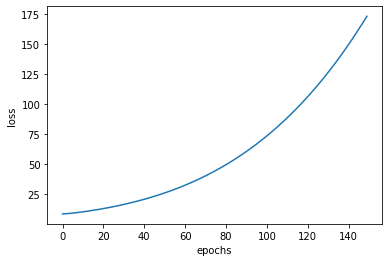

In [33]:
if __name__ =="__main__":
  buffer = Buffer()
  c = Centeral(21,5,1,1,100,200,buffer)
  c.run()

In [22]:
class Buffer:
  def __init__(self):
    self.agent1_reward = []
    self.agent1_value  = []
    self.agent1_msg    = []
    self.agent1_loss   = []
    self.agent1_actor  = []
    self.agent1_critic = []
    self.agent1msg_loss= []
    self.agent1_return = []
    self.agent1_nextv  = []
    self.agent2_reward = []
    self.agent2_value  = []
    self.agent2_msg    = []
    self.agent2_loss   = []
    self.agent2_actor  = []
    self.agent2_critic = []
    self.agent2msg_loss= []
    self.agent2_return = []
    self.agent2_nextv  = []
    self.count         = []
    self.loss          = []
    self.agent1_val    = []
    self.agent2_val    = []
    self.agent1_mg    = []
    self.agent2_mg    = []
  def appending_ag1(self,reward,value,msg,loss,actor,critic,msgl,returns,next_value):
    self.agent1_reward.append(torch.tensor(reward).detach().numpy())
    self.agent1_value.append(torch.tensor(value).detach().numpy())
    self.agent1_msg.append(torch.tensor(msg).detach().numpy())
    self.agent1_loss.append(torch.tensor(loss).detach().numpy())
    self.agent1_actor.append(torch.tensor(actor).detach().numpy())
    self.agent1_critic.append(torch.tensor(critic).detach().numpy())
    self.agent1msg_loss.append(torch.tensor(msgl).detach().numpy())
    self.agent1_return.append(torch.tensor(returns).detach().numpy())
    self.agent1_nextv.append(torch.tensor(next_value).detach().numpy())
  def appending_ag2(self,reward,value,msg,loss,actor,critic,msgl,returns,next_value):
    self.agent2_reward.append(torch.tensor(reward).detach().numpy())
    self.agent2_value.append(torch.tensor(value).detach().numpy())
    self.agent2_msg.append(torch.tensor(msg).detach().numpy())
    self.agent2_loss.append(torch.tensor(loss).detach().numpy())
    self.agent2_actor.append(torch.tensor(actor).detach().numpy())
    self.agent2_critic.append(torch.tensor(critic).detach().numpy())
    self.agent2msg_loss.append(torch.tensor(msgl).detach().numpy())
    self.agent2_return.append(torch.tensor(returns).detach().numpy())
    self.agent2_nextv.append(torch.tensor(next_value).detach().numpy())


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
import matplotlib.pyplot as plt
class Ploting:
  def __init__(self,buffer):
    self.buffer = buffer
    self.agent1_reward()
    self.agent1_loss()
    self.agent1_networks()
    self.agent1_values()
    self.agent1_returns()
    self.agent2_reward()
    self.agent2_loss()
    self.agent2_networks()
    self.agent2_values()
    self.agent2_returns()
    self.agent1_msg_loss()
    self.agent2_msg_loss()
    self.message()
  def agent1_reward(self):
    plt.plot(self.buffer.count,self.buffer.agent1_reward)
    plt.xlabel("epochs")
    plt.ylabel("reward")
    plt.savefig("agent1_reward.png")
    plt.close()
  def agent1_loss(self):
    plt.plot(self.buffer.count,self.buffer.agent1_loss)
    plt.xlabel("epochs")
    plt.ylabel("loss")
    plt.savefig("agent1_loss.png")
    plt.close()
  def agent1_networks(self):
    plt.plot(self.buffer.count,self.buffer.agent1_actor,label = "actor")
    plt.plot(self.buffer.count,self.buffer.agent1_critic,label = "critic")
    plt.xlabel("epochs")
    plt.ylabel("loss")
    plt.legend()
    plt.savefig("agent1_network.png")
    plt.close()
  def agent1_values(self):
    plt.plot(self.buffer.count,self.buffer.agent1_value,label = "agent1_values")
    plt.plot(self.buffer.count,self.buffer.agent1_nextv,label = "agent1_next_values")
    plt.xlabel("epochs")
    plt.ylabel("values")
    plt.legend()
    plt.savefig("agent1_values.png")
    plt.close()    
  def agent1_returns(self):
    plt.plot(self.buffer.count,self.buffer.agent1_return,label = "returns")
    plt.xlabel("epochs")
    plt.ylabel("returns")
    plt.legend()
    plt.savefig("agent1_return.png")
    plt.close()
  def agent1_msg_loss(self):
    plt.plot(self.buffer.count,self.buffer.agent1msg_loss)
    plt.xlabel("epochs")
    plt.ylabel("loss")
    plt.savefig("agent1_msg_loss.png")
    plt.close()
  def agent2_reward(self):
    plt.plot(self.buffer.count,self.buffer.agent2_reward)
    plt.xlabel("epochs")
    plt.ylabel("reward")
    plt.savefig("agent2_reward.png")
    plt.close()
  def agent2_loss(self):
    plt.plot(self.buffer.count,self.buffer.agent2_loss)
    plt.xlabel("epochs")
    plt.ylabel("loss")
    plt.savefig("agent2_loss.png")
    plt.close()
  def agent2_networks(self):
    plt.plot(self.buffer.count,self.buffer.agent2_actor,label = "actor")
    plt.plot(self.buffer.count,self.buffer.agent2_critic,label = "critic")
    plt.xlabel("epochs")
    plt.ylabel("loss")
    plt.legend()
    plt.savefig("agent2_network.png")
    plt.close()
  def agent2_values(self):
    plt.plot(self.buffer.count,self.buffer.agent2_value,label = "agent2_values")
    plt.plot(self.buffer.count,self.buffer.agent2_nextv,label = "agent2_next_values")
    plt.xlabel("epochs")
    plt.ylabel("values")
    plt.legend()
    plt.savefig("agent2_values.png")
    plt.close()    
  def agent2_returns(self):
    plt.plot(self.buffer.count,self.buffer.agent2_return,label = "returns")
    plt.xlabel("epochs")
    plt.ylabel("returns")
    plt.savefig("agent2_return.png")
    plt.legend()
    plt.close()
  def agent2_msg_loss(self):
    plt.plot(self.buffer.count,self.buffer.agent2msg_loss)
    plt.xlabel("epochs")
    plt.ylabel("loss")
    plt.savefig("agent2_msg_loss.png")
    plt.close()
  def message(self):
    plt.plot(self.buffer.count,self.buffer.agent1_msg,label ="agent1_msg")
    plt.plot(self.buffer.count,self.buffer.agent2_msg,label = "agent2_msg")
    plt.xlabel("epochs")
    plt.ylabel("msg")
    plt.legend()
    plt.savefig("agents_msg.png")
    plt.close()